In [1]:
import numpy as np
from numpy import concatenate
import pandas as pd
import tensorflow as tf
import keras
import math
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.linear_model import LinearRegression

from tqdm import tnrange, tqdm_notebook

In [2]:
solar_data = pd.read_csv('./data/train/train.csv',encoding='utf-8')

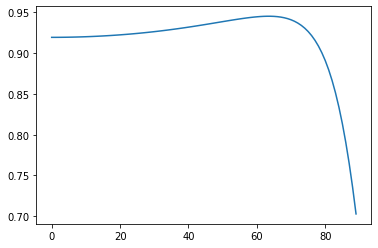

63 0.9451229383187165


In [3]:
corrList = []
corr = lambda p : p['TARGET'].corr(p['GHI'])

def makeCorrList(df):
    result = corr(df)
    corrList.append(result)

for i in range(0,90):
    solar_data['GHI'] = solar_data['DNI']*math.cos(math.pi/180*i)+solar_data['DHI']
    makeCorrList(solar_data)

x = np.arange(0,90)
plt.plot(x,corrList)
plt.show()

print(corrList.index(max(corrList)), max(corrList))

In [4]:
solar_data['GHI'] = solar_data['DNI']*math.cos(math.pi/180*63)+solar_data['DHI']

In [5]:
def eval_dewpoint(T, RH):
    b = 17.62
    c = 243.12
    gamma = (b * T / (c + T)) + math.log(RH / 100.0)
    dewpoint = (c * gamma) / (b - gamma)
    return dewpoint

In [6]:
for i in range(len(solar_data)):
    solar_data.loc[i, ["DP"]] = eval_dewpoint(float(solar_data.loc[i, ["T"]]), solar_data.loc[i , ["RH"]])

In [7]:
solar_data = solar_data.reindex(columns=["Day", "Hour", "Minute", "GHI", "DHI", "DNI", "WS", "RH", "T", "DP", "TARGET"])

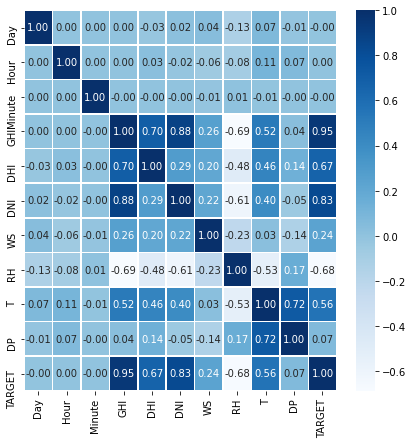

In [8]:
mask = (solar_data.Hour==12)&(solar_data.Minute==00)
# solar_data_filtered = solar_data.loc[mask,:]
# solar_data_filtered.drop(['Day', 'Hour','Minute'], axis='columns', inplace=True)
plt.figure(figsize=(7, 7))
# sns.heatmap(data=solar_data_filtered.corr(), annot=True,fmt='.2f', linewidths=.5, cmap='Blues')
sns.heatmap(data=solar_data.corr(), annot=True,fmt='.2f', linewidths=.5, cmap='Blues')
plt.rcParams['font.family'] = 'NanumGothic'

In [9]:
solar_data.drop(['Day', 'Hour','Minute'], axis='columns', inplace=True)

In [10]:
class CustomHistory(keras.callbacks.Callback):
    def init(self):
        self.train_loss = []
        self.val_loss = []
        
    def on_epoch_end(self, batch, logs={}):
        self.train_loss.append(logs.get('loss'))
        self.val_loss.append(logs.get('val_loss'))

def create_dataset(solar_data, index):
    dataX, dataY = [], []
    for i in range(0,48*7):
        dataX.append(list(np.array(solar_data.loc[index+i].tolist())))
    for i in range(48*7,48*7+48*2):
        dataY.append(solar_data.loc[index+i,'TARGET'])
    return np.array(dataX), np.array(dataY)

def linear_reg(X,y):
    model = linear_model.LinearRegression(fit_intercept = True)
    model.fit(X,y)
    RSS = mean_squared_error(y,model.predict(X)) * len(y)
    R_squared = model.score(X,y)
    return RSS, R_squared

def random_forest(X,y):
    model = RandomForestRegressor(n_estimators=500, max_features=0.25)
    model.fit(X,y)
    RSS = mean_squared_error(y,model.predict(X)) * len(y)
    R_squared = model.score(X,y)
    return RSS, R_squared

def gradient_boosting(X, y):
    model = GradientBoostingRegressor(learning_rate=0.1, n_estimators=500, max_depth=3)
    model.fit(X,y)
    RSS = mean_squared_error(y,model.predict(X)) * len(y)
    R_squared = model.score(X,y)
    return RSS, R_squared    

def support_vector(X, y):
    model = SVR(kernel = 'rbf')
    model.fit(X,y)
    RSS = mean_squared_error(y,model.predict(X)) * len(y)
    R_squared = model.score(X,y)
    return RSS, R_squared 

def extraTree(X, y):
    model = ETR_model = ExtraTreesRegressor(n_estimators=1000)
    model.fit(X,y)
    RSS = mean_squared_error(y,model.predict(X)) * len(y)
    R_squared = model.score(X,y)
    return RSS, R_squared

In [11]:
x_train_for_test=solar_data[["GHI", "DHI", "DNI", "WS", "RH", "T", "DP"]]
y_train_for_test=solar_data['TARGET']

m = len(y_train_for_test)
k = 5
RSS_list, R_squared_list, feature_list = [],[], []
numb_features = []

for k in tnrange(1,len(x_train_for_test.columns) + 1):
    for combo in itertools.combinations(x_train_for_test.columns,k):
        tmp_result = random_forest(x_train_for_test[list(combo)],y_train_for_test)  
        RSS_list.append(tmp_result[0])              
        R_squared_list.append(tmp_result[1])
        feature_list.append(combo)
        numb_features.append(len(combo))   
df = pd.DataFrame({'numb_features': numb_features,'RSS': RSS_list, 'R_squared':R_squared_list,'features':feature_list})
df['min_RSS'] = df.groupby('numb_features')['RSS'].transform(min)
df['max_R_squared'] = df.groupby('numb_features')['R_squared'].transform(max)
df_min = df[df.groupby('numb_features')['RSS'].transform(min) == df['RSS']]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  if __name__ == '__main__':


In [12]:
df_rf=df
df_min_rf=df_min
df_rf.to_csv(f'df_rg.csv', index=False)
df_min_rf.to_csv(f'df_min_rg.csv', index=False)

In [13]:
x_train_for_test=solar_data[["GHI", "DHI", "DNI", "WS", "RH", "T", "DP"]]
y_train_for_test=solar_data['TARGET']

m = len(y_train_for_test)
k = 5
RSS_list, R_squared_list, feature_list = [],[], []
numb_features = []

for k in tnrange(1,len(x_train_for_test.columns) + 1):
    for combo in itertools.combinations(x_train_for_test.columns,k):
        tmp_result = gradient_boosting(x_train_for_test[list(combo)],y_train_for_test)  
        RSS_list.append(tmp_result[0])              
        R_squared_list.append(tmp_result[1])
        feature_list.append(combo)
        numb_features.append(len(combo))   
df = pd.DataFrame({'numb_features': numb_features,'RSS': RSS_list, 'R_squared':R_squared_list,'features':feature_list})
df['min_RSS'] = df.groupby('numb_features')['RSS'].transform(min)
df['max_R_squared'] = df.groupby('numb_features')['R_squared'].transform(max)
df_min = df[df.groupby('numb_features')['RSS'].transform(min) == df['RSS']]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  if __name__ == '__main__':


In [14]:
df_gb=df
df_min_gb=df_min
df_gb.to_csv(f'df_gb.csv', index=False)
df_min_gb.to_csv(f'df_min_gb.csv', index=False)

In [15]:
x_train_for_test=solar_data[["GHI", "DHI", "DNI", "WS", "RH", "T", "DP"]]
y_train_for_test=solar_data['TARGET']

m = len(y_train_for_test)
k = 5
RSS_list, R_squared_list, feature_list = [],[], []
numb_features = []

for k in tnrange(1,len(x_train_for_test.columns) + 1):
    for combo in itertools.combinations(x_train_for_test.columns,k):
        tmp_result = extraTree(x_train_for_test[list(combo)],y_train_for_test)  
        RSS_list.append(tmp_result[0])              
        R_squared_list.append(tmp_result[1])
        feature_list.append(combo)
        numb_features.append(len(combo))   
df = pd.DataFrame({'numb_features': numb_features,'RSS': RSS_list, 'R_squared':R_squared_list,'features':feature_list})
df['min_RSS'] = df.groupby('numb_features')['RSS'].transform(min)
df['max_R_squared'] = df.groupby('numb_features')['R_squared'].transform(max)
df_min = df[df.groupby('numb_features')['RSS'].transform(min) == df['RSS']]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  if __name__ == '__main__':


In [16]:
df_et=df
df_min_et=df_min
df_et.to_csv(f'df_et.csv', index=False)
df_min_et.to_csv(f'df_min_et.csv', index=False)

# 새 섹션

# 새 섹션

# 새 섹션

# 새 섹션